In [1]:
import os
import pandas as pd
import tqdm
from tqdm import tqdm_notebook
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential,load_model
from keras.layers import LSTM, Dense,Conv1D,GlobalAveragePooling1D,MaxPooling1D
from keras.layers import Dropout, Activation, Flatten
from keras.optimizers import SGD

Using TensorFlow backend.


In [4]:
df_ge = pd.read_csv( "us.ge.txt", index_col=0)
print(df_ge.head())

              Open    High     Low   Close   Volume  OpenInt
Date                                                        
1962-01-02  0.6277  0.6362  0.6201  0.6201  2575579        0
1962-01-03  0.6201  0.6201  0.6122  0.6201  1764749        0
1962-01-04  0.6201  0.6201  0.6037  0.6122  2194010        0
1962-01-05  0.6122  0.6122  0.5798  0.5957  3255244        0
1962-01-08  0.5957  0.5957  0.5716  0.5957  3696430        0


In [ ]:
print("checking if any null values are present\n", df_ge.isna().sum())

In [23]:
### In the complete code we can chnage parameters in two cells one is here with respect to data and second one in the Neural network cell where
### we chnage the parameters for the neural network like epochs and batch size 

### Coloumns required for the input data can remove coloumns if need less number of features 
#train_cols = ["Open","High","Low","Close","Volume"]
train_cols = ["Open","High","Low","Close"]
#train_cols = ["Temperature","Outflow"]
label_cols = ["Close"]

#### Number of timesteps required 
TIME_STEPS = 180

df_train, df_test = train_test_split(df_ge, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))

Train and Test size 11246 2812


In [24]:
# Loading training data into X
x = df_train.loc[:,train_cols].values
#noise=abs((np.random.rand(x.shape[0],x.shape[1]) )*10)
#x = x + noise
y = df_train.loc[:,label_cols].values

x_train=x
y_train=y
x_test = df_test.loc[:,train_cols].values
y_test = df_test.loc[:,label_cols].values
print(x_train)

[[ 0.6277  0.6362  0.6201  0.6201]
 [ 0.6201  0.6201  0.6122  0.6201]
 [ 0.6201  0.6201  0.6037  0.6122]
 ...
 [27.292  27.412  27.277  27.382 ]
 [27.254  27.718  27.18   27.718 ]
 [27.718  27.963  27.68   27.912 ]]


In [25]:
def build_timeseries(mat, y_label, TIME_STEPS):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    y_Actual = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] =y_label[TIME_STEPS+i, 0]
        
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [26]:



# Converting the data into timeseries 
X_Train, Y_Train, = build_timeseries(x_train, y_train,TIME_STEPS)


# Converting the data into timeseries 
X_Val, Y_Val = build_timeseries(x_test,y_test, TIME_STEPS)


length of time-series i/o (11066, 180, 4) (11066,)



length of time-series i/o (2632, 180, 4) (2632,)


In [27]:
print(X_Val)
print(Y_Val)

[[[27.935 28.049 27.769 28.049]
  [27.814 28.066 27.776 28.003]
  [28.099 28.178 27.953 28.058]
  ...
  [29.942 30.392 29.917 30.376]
  [30.417 30.424 30.201 30.255]
  [30.337 30.392 29.982 30.15 ]]

 [[27.814 28.066 27.776 28.003]
  [28.099 28.178 27.953 28.058]
  [27.896 28.146 27.867 28.073]
  ...
  [30.417 30.424 30.201 30.255]
  [30.337 30.392 29.982 30.15 ]
  [30.424 30.609 30.337 30.441]]

 [[28.099 28.178 27.953 28.058]
  [27.896 28.146 27.867 28.073]
  [28.066 28.066 27.858 28.058]
  ...
  [30.337 30.392 29.982 30.15 ]
  [30.424 30.609 30.337 30.441]
  [30.441 30.441 30.088 30.11 ]]

 ...

 [[29.494 29.533 29.307 29.475]
  [29.641 29.641 29.641 29.641]
  [29.504 29.601 29.357 29.396]
  ...
  [19.92  20.33  19.86  20.14 ]
  [20.52  20.53  20.08  20.13 ]
  [20.17  20.25  20.12  20.21 ]]

 [[29.641 29.641 29.641 29.641]
  [29.504 29.601 29.357 29.396]
  [29.445 29.533 29.131 29.269]
  ...
  [20.52  20.53  20.08  20.13 ]
  [20.17  20.25  20.12  20.21 ]
  [20.21  20.32  20.07  20.1

In [40]:
# Initialising the RNN
model = Sequential()
height = 18
# Adding the first LSTM layer and some Dropout regularisation
model.add(Conv1D(64,height, activation='relu', input_shape=(X_Train.shape[1],X_Train.shape[2])))
#model.add(Conv1D(64, height, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(64,height, activation='relu'))
#model.add(Conv1D(64,height, activation='relu'))
model.add(GlobalAveragePooling1D())
# Adding a Dense layer and some Dropout regularisation

model.add(Dropout(0.5))
model.add(Dense(20,activation='relu'))
# Adding the output layer

model.add(Dense(1, activation="linear"))




model.compile(optimizer = 'Adadelta', loss = 'mean_squared_error')
# Number of epochs and Batch Sizes can be change 
history=model.fit(X_Train, Y_Train,
           epochs=10,
          validation_data=(X_Val, Y_Val))
# Model summary for number of parameters use in the algorithm 
model.summary()

Train on 11066 samples, validate on 2632 samples
Epoch 1/10
11066/11066 [==============================] - 15s - loss: 13.5312 - val_loss: 48.4046
Epoch 2/10
11066/11066 [==============================] - 14s - loss: 8.8889 - val_loss: 70.9020
Epoch 3/10
11066/11066 [==============================] - 14s - loss: 7.7930 - val_loss: 70.9692
Epoch 4/10
11066/11066 [==============================] - 15s - loss: 7.1268 - val_loss: 73.4831
Epoch 5/10
11066/11066 [==============================] - 14s - loss: 6.4887 - val_loss: 98.2576
Epoch 6/10
11066/11066 [==============================] - 14s - loss: 5.8914 - val_loss: 80.2043
Epoch 7/10
11066/11066 [==============================] - 14s - loss: 5.6783 - val_loss: 115.0191
Epoch 8/10
11066/11066 [==============================] - 13s - loss: 5.4402 - val_loss: 93.2470
Epoch 9/10
11066/11066 [==============================] - 13s - loss: 5.1314 - val_loss: 120.2418
Epoch 10/10
11066/11066 [==============================] - 13s - loss: 4.50

In [41]:
model.save('my_model_1_CNN.hdf5')

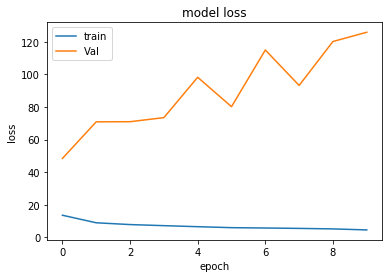

In [42]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()


In [43]:
#print(model.predict(X_Val)

x_buffer = np.zeros((1,X_Train.shape[1], X_Train.shape[2]))
#model.predict(X_Val)
for i in range(100):
    x_buffer[0,:] = X_Val[i,:]
    print(model.predict( x_buffer),Y_Val[i])
   


[[14.126834]] 30.441
[[14.131354]] 30.11
[[14.137741]] 30.022
[[14.139987]] 29.596
[[14.144247]] 30.046
[[14.14937]] 30.159000000000002
[[14.151141]] 29.828000000000003
[[14.1545925]] 30.305
[[14.1588]] 30.432
[[14.159759]] 30.691999999999997
[[14.162753]] 30.65
[[14.165893]] 31.633000000000003
[[14.166373]] 31.456
[[14.168918]] 31.238000000000003
[[14.17181]] 30.787
[[14.172607]] 30.761999999999997
[[14.175248]] 30.609
[[14.178153]] 30.641
[[14.179299]] 30.691999999999997
[[14.182102]] 30.820999999999998
[[14.185163]] 30.804000000000002
[[14.1862]] 31.158
[[14.189214]] 31.029
[[14.192263]] 30.98
[[14.193657]] 31.092
[[14.197257]] 30.513
[[14.200912]] 30.753
[[14.203455]] 31.398000000000003
[[14.208127]] 31.802
[[14.211836]] 32.3
[[14.215309]] 32.775999999999996
[[14.220909]] 32.565
[[14.225391]] 32.775999999999996
[[14.230311]] 32.3
[[14.237673]] 32.864000000000004
[[14.243621]] 32.382
[[14.250123]] 32.542
[[14.259295]] 31.825
[[14.266891]] 31.229
[[14.275131]] 31.618000000000002
[[14

In [44]:
predict =model.predict(X_Val)

predict

array([[14.126833],
       [14.131353],
       [14.137739],
       ...,
       [12.500067],
       [12.475724],
       [12.454151]], dtype=float32)

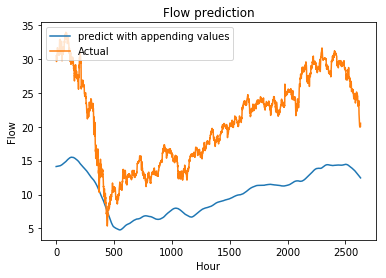

In [45]:
plt.figure()
plt.plot((predict))
plt.plot(Y_Val)

plt.title('Flow prediction')
plt.ylabel('Flow')
plt.xlabel('Hour')
plt.legend(['predict with appending values','Actual'], loc='upper left')

#plt.savefig("figurelinearStandardNormalized.jpg")
plt.show()

In [46]:
mean_square_root = mean_squared_error(predict, Y_Val)
mean_square_root

125.92080823233421

In [47]:
square_root=np.sqrt(mean_square_root)
square_root

11.22144412419071